In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook
import itertools

# ODEs Time-Stepping

The ODE $y^\prime = \lambda y$ with the initial condition $y(0) = 1$ has the solution
$$
y(t) = e^{\lambda t}
$$

In [37]:
def foo(y_0, t, lam):
    return np.exp(lam*t)

def forward(y_0, delta_t, lam, n):
    return y_0 * (1+lam*delta_t)**n
        
def backward(y_0, delta_t, lam, n):
    return y_0 * (1-lam*delta_t)**-n

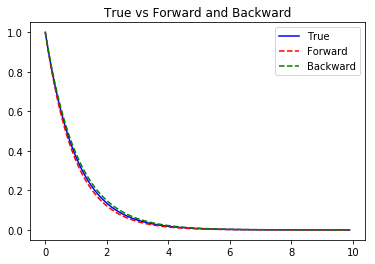

In [35]:
delta_t = .1
n = 100
lam = -1
y_0 = 1

ts = [delta_t * i for i in range(n)]
y_true = [foo(y_0, delta_t*i, lam) for i in range(n)]
y_forward = [forward(y_0, delta_t, lam, i) for i in range(n)]
y_backward = [backward(y_0, delta_t, lam, i) for i in range(n)]

plt.title('True vs Forward and Backward')
plt.plot(ts, y_true, '-b', label='True')
plt.plot(ts, y_forward, '--r', label='Forward')
plt.plot(ts, y_backward, '--g', label='Backward')
plt.legend()

In [100]:
target_t = 5
time_steps = [2**i for i in range(1,20)]
lam = -1
y_0 = 1

fw_errors = []
bk_errors = []

steps = [target_t/t for t in time_steps]

for step in time_steps:
    delta_t = target_t/step
    fw = forward(y_0, delta_t, lam, step)
    back = backward(y_0, delta_t, lam, step)
    true_value = foo(y_0, target_t, lam)
    fw_errors.append(np.abs(fw - true_value))
    bk_errors.append(np.abs(back - true_value))
    
print('fw_err\t\tfw_ratio\tback_err\tback_ratio')
print('%f\tN/A \t\t%f\tN/A  ' % (fw_errors[0], bk_errors[0]) )
for fw, fw_prev, bk, bk_prev in zip(fw_errors[1:], fw_errors[:-1], bk_errors[1:], bk_errors[:-1]):
    print('%f\t%f\t%f\t%f' % (fw, fw/fw_prev, bk, bk/bk_prev))
    
        


fw_err		fw_ratio	back_err	back_ratio
136.163159	N/A 		147.968715	N/A  
122.784253	0.901744	107.586841	0.727092
99.791819	0.812741	2408.699476	22.388421
70.861875	0.710097	253.041738	0.105053
44.263977	0.624652	81.285708	0.321234
25.152788	0.568245	33.972039	0.417934
13.475265	0.535736	15.654073	0.460793
6.984065	0.518288	7.527161	0.480844
3.556640	0.509251	3.692314	0.490532
1.794867	0.504652	1.828779	0.495293
0.901621	0.502333	0.910098	0.497654
0.451863	0.501168	0.453983	0.498828
0.226196	0.500584	0.226726	0.499415
0.113164	0.500292	0.113297	0.499707
0.056599	0.500146	0.056632	0.499854
0.028303	0.500073	0.028312	0.499927
0.014153	0.500037	0.014155	0.499963
0.007077	0.500018	0.007077	0.499982
0.003538	0.500009	0.003539	0.499991


In [19]:
l = zip(fw_errors[1:], fw_errors[:-1], bk_errors[1:], bk_errors[:-1])
for a, b, c, d in l:
    print(a,b,c,d)

0.09813016014842982 0.36787944117144233 0.07316613614786646 0.13212055882855767
0.04029005673169514 0.09813016014842982 0.03594125654955485 0.07316613614786646
0.018421153106358418 0.04029005673169514 0.017533267781211725 0.03594125654955485
0.00882228696598622 0.018421153106358418 0.00862363532858676 0.017533267781211725
0.004318736626198916 0.00882228696598622 0.004271903885053968 0.00862363532858676
0.00213681456395598 0.004318736626198916 0.002125455235711504 0.004271903885053968
0.0010628353081024722 0.00213681456395598 0.0010600387870733918 0.002125455235711504
0.0005300328463224702 0.0010628353081024722 0.000529339111767918 0.0010600387870733918


# 1-D Heat Equation

In [15]:
n = 10
a = 0
b = 0
l = 1
delta_t = .01

def f(x):
    return np.sin(2*np.pi/l * x) + x*(1-x)

xs = np.linspace(0, l, n)
u = f(xs)
h = 1/n
D = np.diag([1] + [-2]*(n-2) + [1]) + np.diag([0]+[1]*(n-2), 1) + np.diag([1]*(n-2) + [0], -1)
us = [u]
for i in range(100):
    us.append(us[-1] + delta_t/h**2 * D@us[-1])

In [16]:
print(us)

[array([ 0.00000000e+00,  7.41553042e-01,  1.15764726e+00,  1.08824763e+00,
        5.88933724e-01, -9.51065631e-02, -6.43803182e-01, -8.11968247e-01,
       -5.44022178e-01, -2.44929360e-16]), array([ 0.00000000e+00,  4.16094217e-01,  6.72153409e-01,  6.58333357e-01,
        4.04207339e-01,  4.02371051e-02, -2.63271628e-01, -3.75857112e-01,
       -2.67946069e-01, -4.89858720e-16]), array([ 0.00000000e+00,  2.56059191e-01,  4.02274166e-01,  4.18027391e-01,
        2.94363122e-01,  1.00698606e-01, -7.23483789e-02, -1.55360585e-01,
       -1.07911043e-01, -9.79717439e-16]), array([ 0.00000000e+00,  1.46214974e-01,  2.71812417e-01,  2.78609897e-01,
        2.24362875e-01,  1.21316138e-01,  1.76863995e-02, -2.48988366e-02,
       -4.74495422e-02, -1.95943488e-15]), array([ 0.00000000e+00,  1.25597443e-01,  1.53012454e-01,  2.17565395e-01,
        1.75563160e-01,  1.20733136e-01,  7.87309016e-02, -4.86430613e-03,
        2.25507056e-02, -3.91886976e-15]), array([ 0.00000000e+00,  2.7415011

<IPython.core.display.Javascript object>


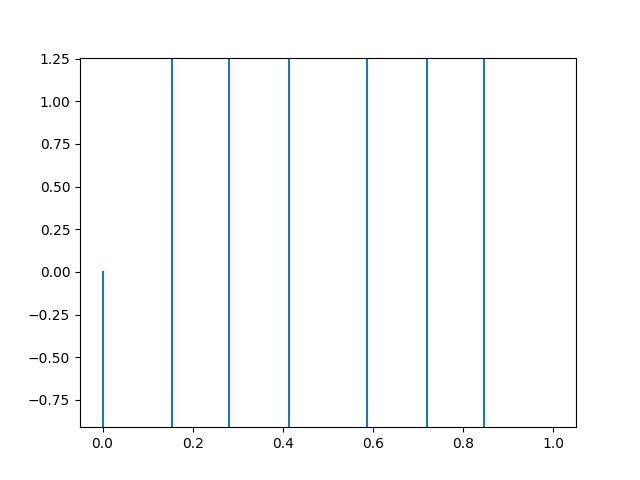

In [17]:
fig, ax = plt.subplots()

xs = np.arange(0, 1, 0.01)
xs = np.linspace(0,l,n)
line, = ax.plot(xs, f(xs))


def animate(i):
    line.set_ydata(us[i])  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(xs, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 99), init_func=init,
                              interval=25, blit=True)

#ani.save('test.mp4', writer='imagemagick', fps=30)
                              
plt.show()

In [49]:
xs

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

<IPython.core.display.Javascript object>


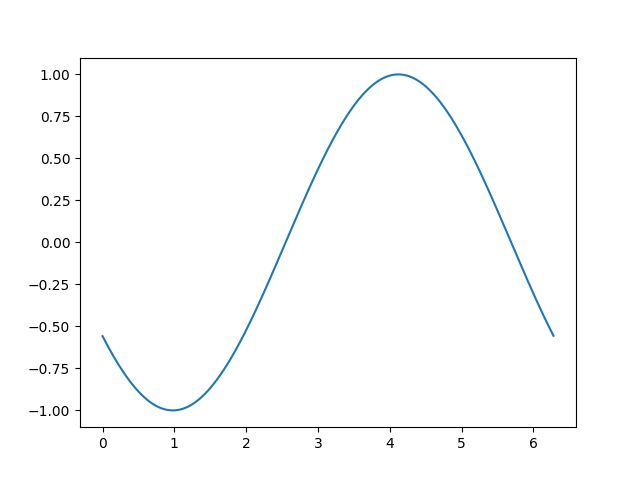

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i/10.0))  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)

#ani.save('test.mp4', writer='imagemagick', fps=30)
                              
plt.show()

In [90]:
def html_table(lol, headers, string_formating='{:.8f}'):
    assert len(lol) == len(headers)
    n = len(lol[0])
    for l in lol:
        assert len(l) == n
    ret = '<table>\n'
    for header in headers:
        ret += '\t<th>' + header + '</th>'
    ret += '\n'
    rows = zip(*lol)
    for row in rows:
        ret += '\t<tr>\n\t\t'
        for v in row:
            if isinstance(v, str):
                str_val = v
            else:
                str_val = string_formating.format(v)
            ret += '<td>' + str_val + '</td>'
        ret += '\n\t</tr>\n'
    ret += '</table>'
    return ret
    
    

In [95]:
fw_ratio = ['N/A'] + [e/p for e, p in zip(fw_errors[1:], fw_errors[:-1])]
bk_ratio = ['N/A'] + [e/p for e, p in zip(bk_errors[1:], bk_errors[:-1])]
print(html_table((steps, fw_errors, fw_ratio, bk_errors, bk_ratio), ('$\Delta t$', 'fw_err','fw_ratio','bk_err','bk_ratio')))

<table>
	<th>$\Delta t$</th>	<th>fw_err</th>	<th>fw_ratio</th>	<th>bk_err</th>	<th>bk_ratio</th>
	<tr>
		<td>2.50000000</td><td>2.24326205</td><td>N/A</td><td>0.07489471</td><td>N/A</td>
	</tr>
	<tr>
		<td>1.25000000</td><td>0.00283170</td><td>0.00126231</td><td>0.03228050</td><td>0.43101171</td>
	</tr>
	<tr>
		<td>0.62500000</td><td>0.00634688</td><td>2.24137008</td><td>0.01382915</td><td>0.42840588</td>
	</tr>
	<tr>
		<td>0.31250000</td><td>0.00424701</td><td>0.66914871</td><td>0.00615675</td><td>0.44520049</td>
	</tr>
	<tr>
		<td>0.15625000</td><td>0.00238442</td><td>0.56143559</td><td>0.00286366</td><td>0.46512633</td>
	</tr>
	<tr>
		<td>0.07812500</td><td>0.00125505</td><td>0.52635250</td><td>0.00137496</td><td>0.48014022</td>
	</tr>
	<tr>
		<td>0.03906250</td><td>0.00064288</td><td>0.51223998</td><td>0.00067287</td><td>0.48937381</td>
	</tr>
	<tr>
		<td>0.01953125</td><td>0.00032524</td><td>0.50590302</td><td>0.00033273</td><td>0.49449984</td>
	</tr>
	<tr>
		<td>0.00976562</td><t

In [82]:
isinstance('a', str)

True